# 02-PCA-analysis-and-clustering

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

/Applications/anaconda3/envs/adsml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 1. Apply PCA analysis on the training dataset. Make a scree plot, how many PCA components explain 10%, 20%, …, 90% and 100% of the variance?

In [2]:
# Loading train high-level features
train_features = np.load('train_features.npz')['features']
print("Train Features Shape:", train_features.shape)

Train Features Shape: (280, 1280)


As the dimentions are not that big, I will work on a dataframe

In [3]:
features = pd.DataFrame(train_features) # convert into df
X = features.values #extract features values

# Rescale feature values

scaler = StandardScaler()
X_rescaled = scaler.fit_transform(X)

as a warm-up I will start by extracting 2 principal components

In [4]:
# Create PCA transformer
pca = PCA(n_components=2)

# Apply PCA
pca.fit(X_rescaled, y=None)

# Project data onto the first two components
X_2d = pca.transform(X_rescaled)
X_2d[0:5] # first 5 observations (only 2 features left)

array([[16.24100844, -5.02372368],
       [10.11713657,  3.79306011],
       [14.71315867, -7.27599152],
       [-3.77483238, 10.27667588],
       [-9.18901649,  8.21934   ]])

In [5]:
# Get explained variance
var_explained=pca.explained_variance_ratio_
print('variance explaind by the first and second pc: ',var_explained)
p2c_var_explained =var_explained[0]+var_explained[1]
print('portion of variance explained with 2 principal components: ', round(p2c_var_explained*100), '%')

variance explaind by the first and second pc:  [0.09500885 0.05561277]
portion of variance explained with 2 principal components:  15 %


Observation: <br>
With only 2 pc we are not getting very far in terms of extrating information from the data. If the two strongest pc only get 15 jointly, we will probably have to get many more of them for the further analysis to have sense, or perhaps not use PCA at all.

In [6]:
# Create PCA transformer
pca2 = PCA(n_components=None)

# Apply PCA
pca2.fit(X_rescaled, y=None)

# Project data onto the first two components
X_2d2 = pca2.transform(X_rescaled)


In [7]:
# Get explained variance
var_explained2=pca2.explained_variance_ratio_
var_explained_list =var_explained2.tolist()
print('number of principal components(when unrestricted): ',len(var_explained_list))
print('portion of variance explained by these pc: ', round(sum(var_explained_list*100)),'%')


number of principal components(when unrestricted):  280
portion of variance explained by these pc:  100 %


Observation: <br>
It appears that 100% of information from 1280 high level features can be resumed with 280 principal components. This allows to substancially reduce the dataset without any information loss.

What percentage of variance is explained with the different number of principal components? The plot will allow to understand this relationship:

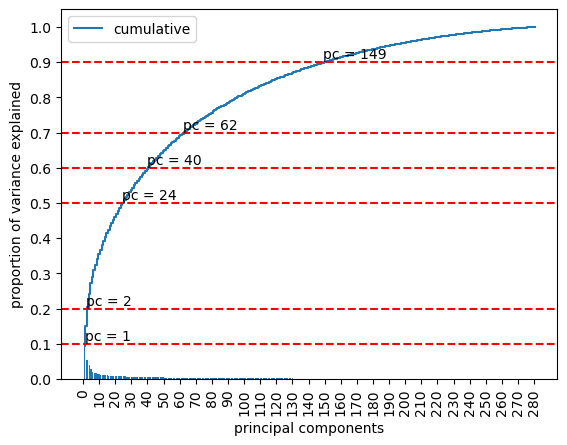

In [8]:
# Create bar plot
xcor = np.arange(1, len(var_explained2) + 1)
plt.bar(xcor, var_explained2)

# Add cumulative sum
pve_cumsum = np.cumsum(var_explained2)
plt.step(xcor + 0.5, pve_cumsum, label="cumulative")

# Add labels
plt.xlabel("principal components")
plt.ylabel("proportion of variance explained")
plt.legend()

# x and y ticks:
plt.xticks(np.arange(0, len(var_explained2) + 1, 10), rotation='vertical')
plt.yticks(np.arange(0, 1.1, 0.1))

# Draw horizontal lines 
y_values = [0.1, 0.2, 0.5, 0.6, 0.7, 0.9]
for y_value in y_values:
    plt.axhline(y=y_value, color='r', linestyle='--')
    # Find the corresponding x-axis number
    x_value = np.argmax(pve_cumsum >= y_value)
    plt.text(x_value, y_value + 0.01, f'pc = {x_value}')

plt.show()

Interpretation:
    
The first 41 pc allow to explain 60% of information in 1280 high level features. Adding 20 pcs, gives us another 10% of information and beyond 63 each additional pcs contributs decreasingly in explaining variance. Beyond 150 pcs, the information gain is very poor.


#### 2. After transforming the training dataset using the first two PCA components, visualize the transformed data on a 2D-plot and use 6 different colors to designate the 6 categories. What can you say about the results?

In [9]:
# Adding labels into outr data

labels = np.load('labelled_train_features.npz')['labels']
labels_df = pd.DataFrame(labels) # convert into df
y = labels_df.values

categories = np.unique(y)
print('unique labels: ', categories)

unique labels:  [0 1 2 3 4 5]


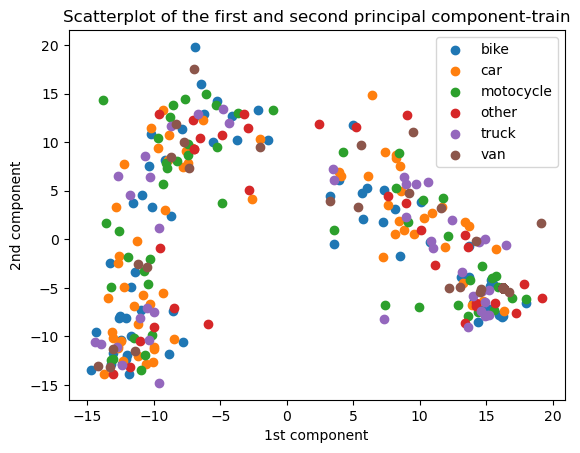

In [10]:
# plotting:

for i in [0, 1, 2, 3, 4, 5]:
    indices = np.where(y == i)
    
    if i == 0: vehicle = 'bike'
    elif i == 1: vehicle = 'car'
    elif i == 2: vehicle = 'motocycle'
    elif i == 3: vehicle = 'other'
    elif i == 4: vehicle = 'truck'
    elif i == 5: vehicle = 'van'
    
    plt.scatter(X_2d[indices, 0], X_2d[indices, 1], label=vehicle)

# Labels and legend
plt.legend()
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.title('Scatterplot of the first and second principal component-train')
plt.show()

Observation: <br>
All categories are well disperced along the 2 axes (no evident clusters) and the relationship between pc 1 and 2 is unlinear

#### 3. On the 2D transformed training data, apply k-means clustering with k equals 6. Plot the same 2D-plot as above but this time use the colors to distinguish between the six clusters obtained by k-means. Do the 6 clusters of k-means align with the 6 categories from above?

In [11]:
# Create k-means object
kmeans = KMeans(n_clusters=6, random_state=0)  # Fix results
# Fit it to the data
kmeans.fit(X_2d, y=None)


KMeans(n_clusters=6, random_state=0)

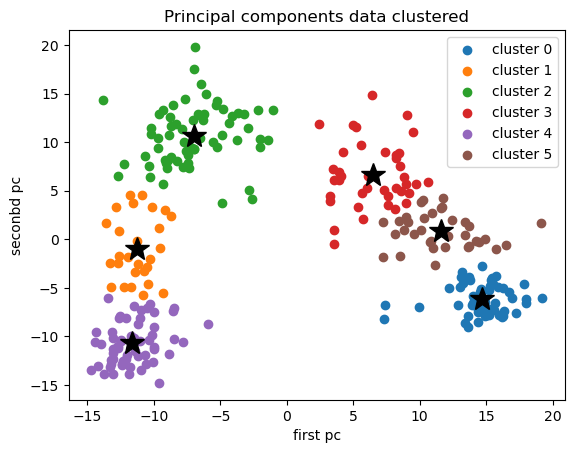

In [12]:
# Plot clusters
for cluster in [0, 1, 2,3,4,5]:

    idx = kmeans.labels_ == cluster

    # Plot points
    plt.scatter(
        X_2d[idx, 0],  
        X_2d[idx, 1],  
        label="cluster {}".format(cluster),
    )

    centroid = kmeans.cluster_centers_[cluster]
    plt.plot(centroid[0], centroid[1], marker="*", color="black", markersize=18)

plt.legend()
plt.xlabel("first pc")
plt.ylabel("seconbd pc")
plt.title('Principal components data clustered')
plt.show()


Observation: <br>
The short answer is: no, no alignment. There was no need to do the cluster analysis to respond it, on 'Scatterplot of the first and second principal component' figure the data clump up into seceral clusters but its visible that none of them is composed of a dominant vehicle type.

#### 4. Using the first two PCA components obtained form the training dataset, transform the test dataset. Visualize the transformed data on a 2D-plot and use 6 different colors to designate the 6 categories. Based on this visualization, how many sample in the test dataset you think might be hard to classify?

In [13]:
# Loading test high-level features
test_features = np.load('test_features.npz')['features']
print("Test Features Shape:", test_features.shape)

Test Features Shape: (50, 1280)


In [14]:
# Adding test labels 

labels = np.load('labelled_test_features.npz')['labels']
labels_df = pd.DataFrame(labels) # convert into df
y = labels_df.values

In [15]:
# preparing the test features
features_test = pd.DataFrame(test_features) # convert into df
X_test = features_test.values 
X_rescaled_test = scaler.fit_transform(X_test)

In [16]:
# Projecting data onto the first two components
X_2d_test = pca.transform(X_rescaled_test)

# quick check if this projection yields different results from those done on train
print('first 3 obs from test:')
print(X_2d_test[0:3]) 
print('')
print('first 3 obs from train:')
print(X_2d[0:3])  


first 3 obs from test:
[[13.63647162 -7.48760172]
 [14.25653181 -6.70258797]
 [18.06913059 -6.83650336]]

first 3 obs from train:
[[16.24100844 -5.02372368]
 [10.11713657  3.79306011]
 [14.71315867 -7.27599152]]


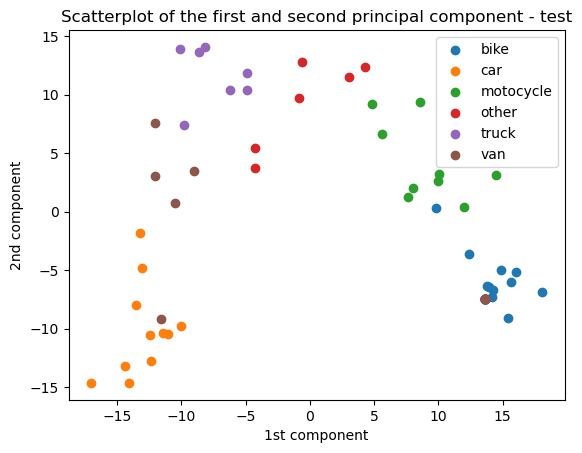

In [17]:
# plotting:

for i in [0, 1, 2, 3, 4, 5]:
    indices = np.where(y == i)
    
    if i == 0: vehicle = 'bike'
    elif i == 1: vehicle = 'car'
    elif i == 2: vehicle = 'motocycle'
    elif i == 3: vehicle = 'other'
    elif i == 4: vehicle = 'truck'
    elif i == 5: vehicle = 'van'
    
    plt.scatter(X_2d_test[indices, 0], X_2d_test[indices, 1], label=vehicle)

# Labels and legend
plt.legend()
plt.xlabel("1st component")
plt.ylabel("2nd component")
plt.title('Scatterplot of the first and second principal component - test')
plt.show()

Observation: <br>
The distribution of categories in the test set is very different than the one in the train set, indicating that we would probably deal with alot of missclassification. this should not come as a surprise as we've already checked that these 2 pc explain around 15% of information (variance explained) from the train set. This is very little and assuming the variance explained with these 2 pc on the test set is no expected to be higher it is likely that this information explained in the test and train sets  simply doesnt overlap. 